<a href="https://colab.research.google.com/github/swastik7sharma/temp/blob/main/final_ev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
print('Swastik')

Swastik


In [1]:
print('hello')

hello


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import datetime
from scipy.io import loadmat

# Your load_data function comes here (copy-paste)
def load_data(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []

  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

# Load and preprocess
dataset_val, capacity_val = load_data('B0006')

attrib = ['capacity', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']
sc = StandardScaler()
dataset_val_scaled = sc.fit_transform(dataset_val[attrib])

# Create sequences
X_train = np.array([dataset_val_scaled[i:i+10] for i in range(len(dataset_val_scaled) - 10)])
y_train = dataset_val['capacity'][10:].values

# Baseline capacity
C = dataset_val['capacity'].iloc[0]


Total data in dataset:  616
[1, np.uint8(24), datetime.datetime(2008, 4, 2, 15, 25, 41), np.float64(2.035337591005598), np.float64(4.179799607333447), np.float64(-0.0023663271409738672), np.float64(24.277567510331888), np.float64(-0.0006), np.float64(0.0), np.float64(0.0)]


In [3]:
def plot_soh(new_soh, model_name):
    plt.figure(figsize=(16, 10))
    plt.plot(new_soh['cycle'], new_soh['SoH'], label='Actual SoH')
    plt.plot(new_soh['cycle'], new_soh['NewSoH'], label=f'Predicted SoH ({model_name})', linestyle='--')
    plt.xlabel('Cycle')
    plt.ylabel('State of Health (SoH)')
    plt.title(f'Discharge B0006 - Actual vs Predicted SoH ({model_name})')
    plt.legend()
    plt.show()

def prepare_soh(dataset_val, predictions, baseline_C):
    soh_actual = dataset_val['capacity'][10:] / baseline_C
    soh_pred_scaled = predictions.flatten() / baseline_C

    new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1)].iloc[10:].reset_index()
    new_soh['SoH'] = soh_actual.values
    new_soh['NewSoH'] = soh_pred_scaled
    new_soh = new_soh.groupby(['cycle']).mean().reset_index()
    return new_soh


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,497 (72.25 KB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2328 - val_loss: 0.0150
Epoch 2/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0909 - val_loss: 0.0217
Epoch 3/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0575 - val_loss: 0.0292
Epoch 4/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0312 - val_loss: 0.0558
Epoch 5/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0190 - val_loss: 0.0169
Epoch 6/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0171 - val_loss: 0.0102
Epoch 7/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0165 - val_loss: 0.0101
Epoch 8/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0159 - val_loss: 0.0059
Epoch 9/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0155 - val_loss: 0.0093
Epoch 10/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0157 - val_loss: 0.0098
Epoch 11/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0156 - val_loss: 0.0076
Epoch 12/50
1257/1257 ━━━━━━

1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


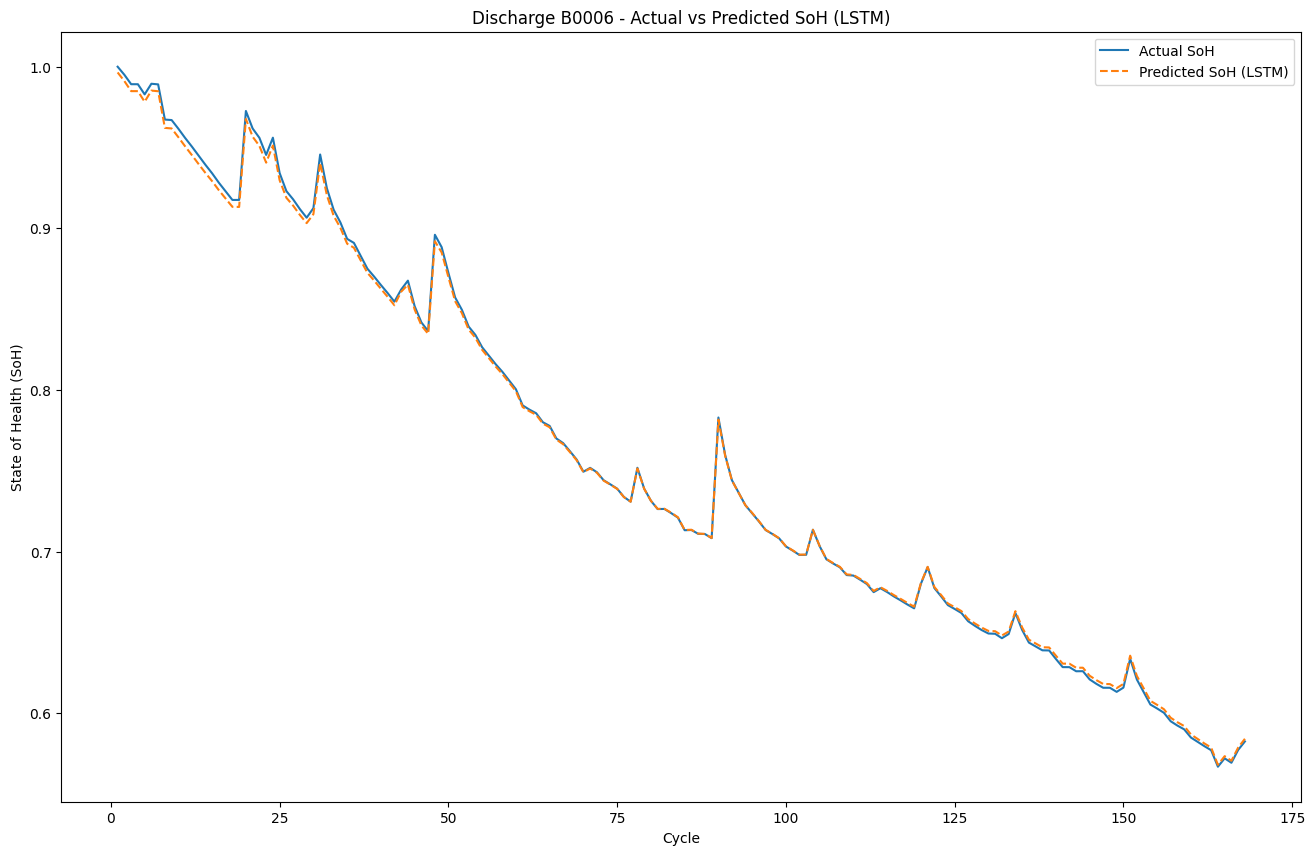

In [4]:
# LSTM Model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_absolute_error')
lstm_model.summary()

# Train
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Save model
lstm_model.save('lstm_model.h5')

# Predict
lstm_pred = lstm_model.predict(X_train)

# Save prediction
np.save('lstm_predictions.npy', lstm_pred)

# Prepare and plot
lstm_soh = prepare_soh(dataset_val, lstm_pred, C)
plot_soh(lstm_soh, 'LSTM')


1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


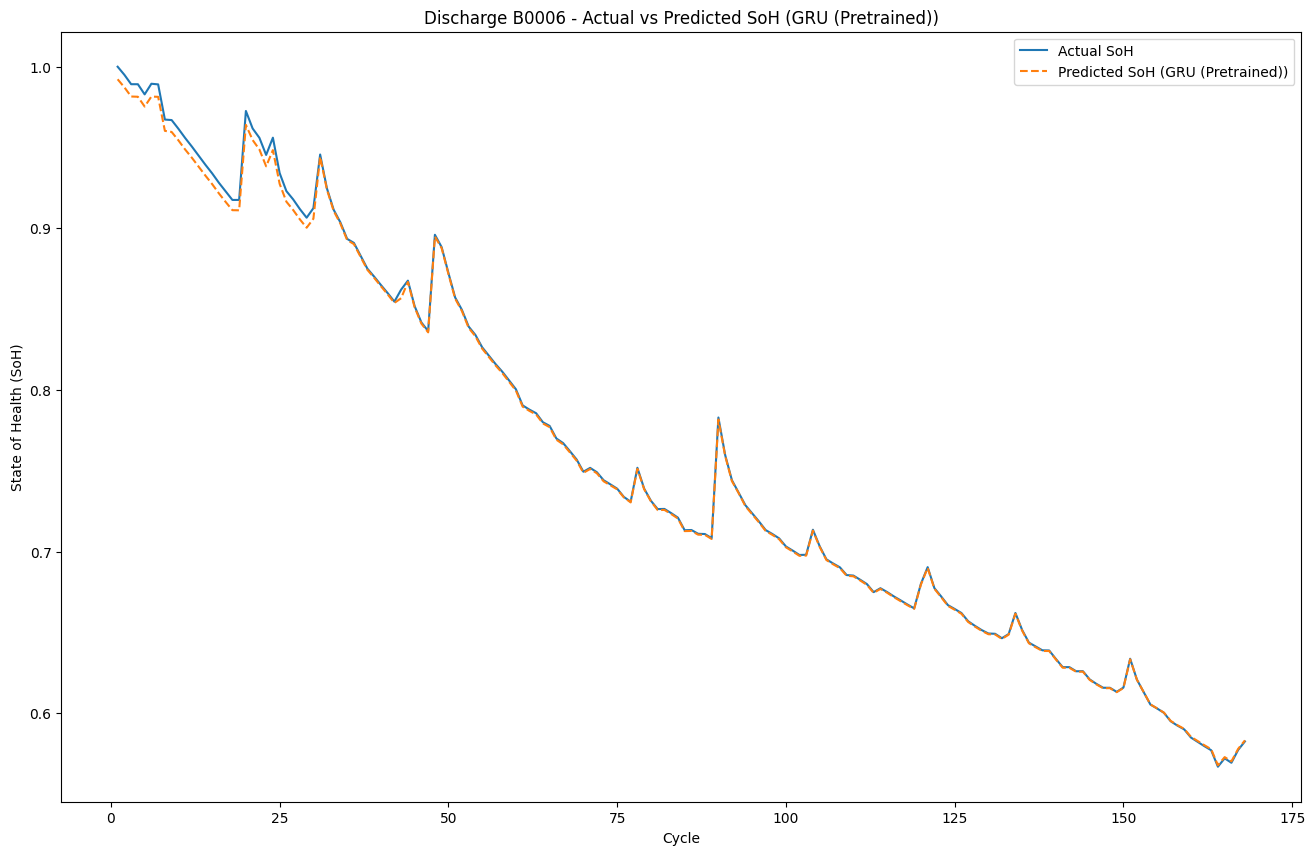

In [5]:
# Load the saved GRU model
gru_model = tf.keras.models.load_model('gru_model.h5')

# Predict
gru_pred = gru_model.predict(X_train)

# Save predictions
np.save('gru_predictions.npy', gru_pred)

# Prepare SoH
gru_soh = prepare_soh(dataset_val, gru_pred, C)
plot_soh(gru_soh, 'GRU (Pretrained)')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,497 (134.75 KB)

 Trainable params: 34,497 (134.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.2074 - val_loss: 0.1091
Epoch 2/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0904 - val_loss: 0.0637
Epoch 3/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0614 - val_loss: 0.0458
Epoch 4/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0343 - val_loss: 0.1000
Epoch 5/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0208 - val_loss: 0.0456
Epoch 6/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0188 - val_loss: 0.0431
Epoch 7/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0182 - val_loss: 0.0470
Epoch 8/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0177 - val_loss: 0.0584
Epoch 9/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0174 - val_loss: 0.0413
Epoch 10/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0172 - val_loss: 0.0491
Epoch 11/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0172 - val_loss: 0.0506
Epoch 12/50
1257/1257 ━━━━━━━

1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


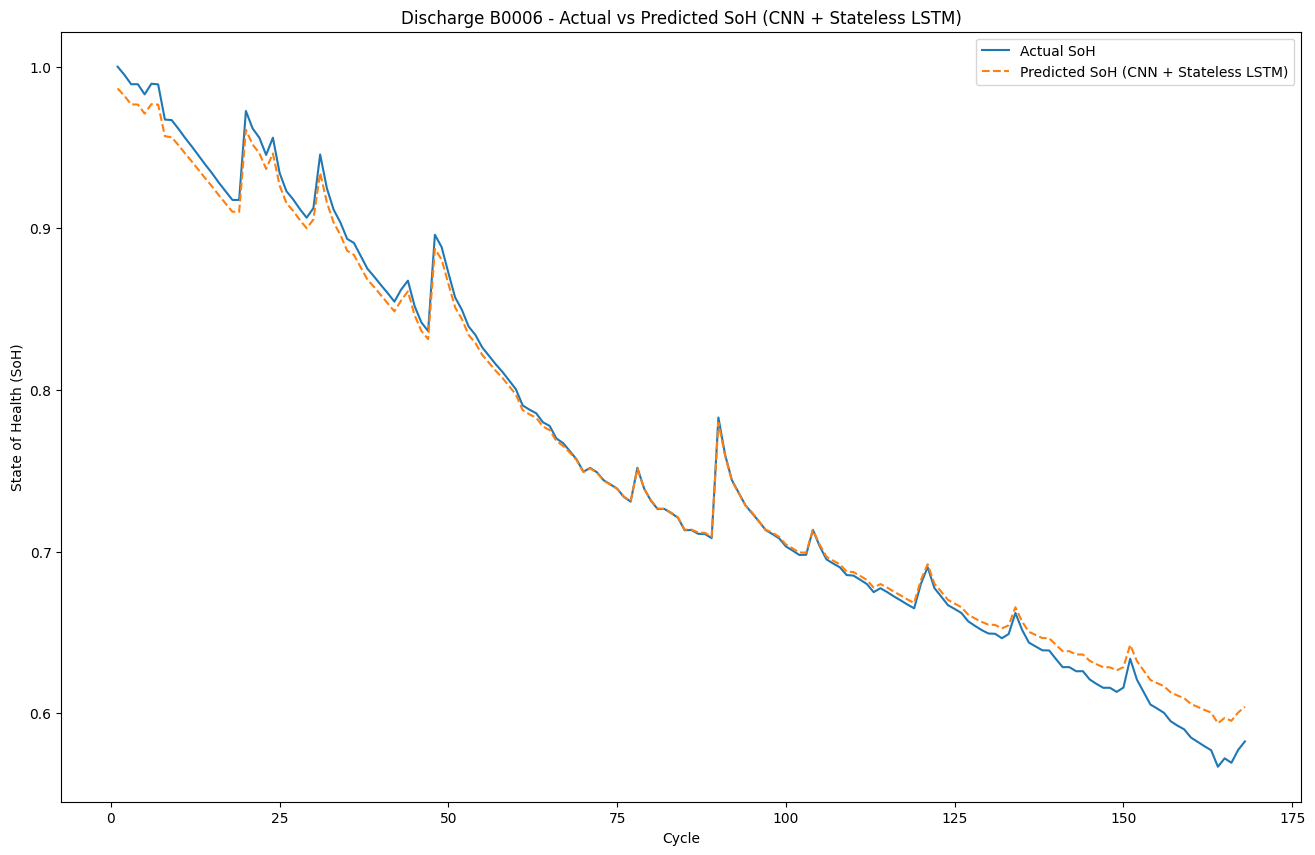

In [6]:
cnn_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, activation='relu', stateful=False, return_sequences=False),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

cnn_lstm_model.compile(optimizer='adam', loss='mean_absolute_error')
cnn_lstm_model.summary()

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

cnn_lstm_model.save('cnn_lstm_model.h5')
cnn_lstm_pred = cnn_lstm_model.predict(X_train)
np.save('cnn_lstm_predictions.npy', cnn_lstm_pred)

cnn_lstm_soh = prepare_soh(dataset_val, cnn_lstm_pred, C)
plot_soh(cnn_lstm_soh, 'CNN + Stateless LSTM')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 8, 64)          │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,585 (264.00 KB)

 Trainable params: 67,585 (264.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1992 - val_loss: 0.0711
Epoch 2/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0764 - val_loss: 0.0432
Epoch 3/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0579 - val_loss: 0.0498
Epoch 4/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0424 - val_loss: 0.0329
Epoch 5/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0279 - val_loss: 0.0748
Epoch 6/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0178 - val_loss: 0.0482
Epoch 7/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0160 - val_loss: 0.0292
Epoch 8/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0155 - val_loss: 0.0303
Epoch 9/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0155 - val_loss: 0.0259
Epoch 10/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0155 - val_loss: 0.0258
Epoch 11/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0154 - val_loss: 0.0247
Epoch 12/50
1257/1257 ━━━

1572/1572 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


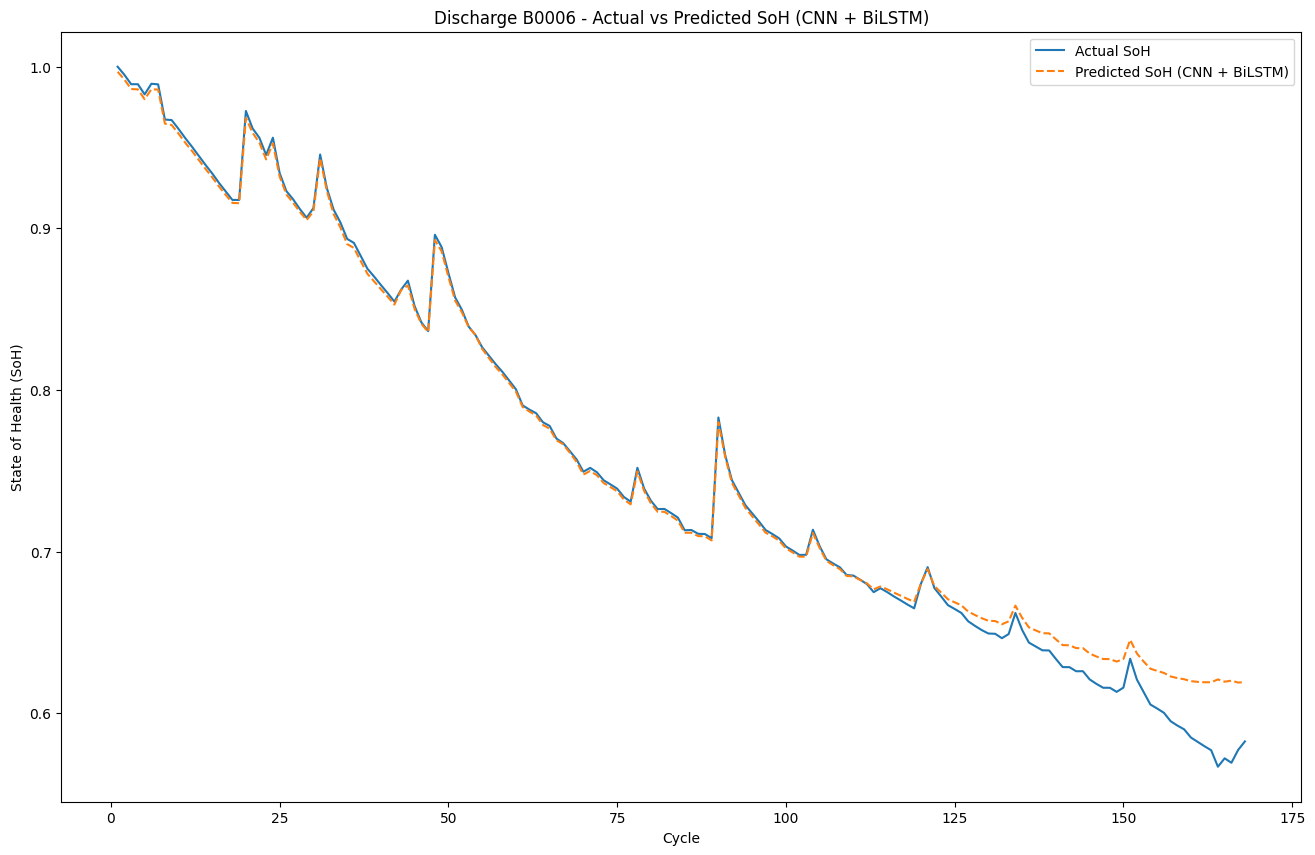

In [7]:
cnn_bilstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu')),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

cnn_bilstm_model.compile(optimizer='adam', loss='mean_absolute_error')
cnn_bilstm_model.summary()

history_cnn_bilstm = cnn_bilstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

cnn_bilstm_model.save('cnn_bilstm_model.h5')
cnn_bilstm_pred = cnn_bilstm_model.predict(X_train)
np.save('cnn_bilstm_predictions.npy', cnn_bilstm_pred)

cnn_bilstm_soh = prepare_soh(dataset_val, cnn_bilstm_pred, C)
plot_soh(cnn_bilstm_soh, 'CNN + BiLSTM')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 8, 64)          │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout (MCDropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,497 (134.75 KB)

 Trainable params: 34,497 (134.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.2296 - val_loss: 0.0771
Epoch 2/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0927 - val_loss: 0.0709
Epoch 3/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0610 - val_loss: 0.0557
Epoch 4/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0333 - val_loss: 0.0844
Epoch 5/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0202 - val_loss: 0.0554
Epoch 6/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0194 - val_loss: 0.0460
Epoch 7/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0194 - val_loss: 0.0478
Epoch 8/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0191 - val_loss: 0.0547
Epoch 9/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0191 - val_loss: 0.0516
Epoch 10/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0191 - val_loss: 0.0522
Epoch 11/50
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0189 - val_loss: 0.0555
Epoch 12/50
1257/1257 ━━━━━━━

1572/1572 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


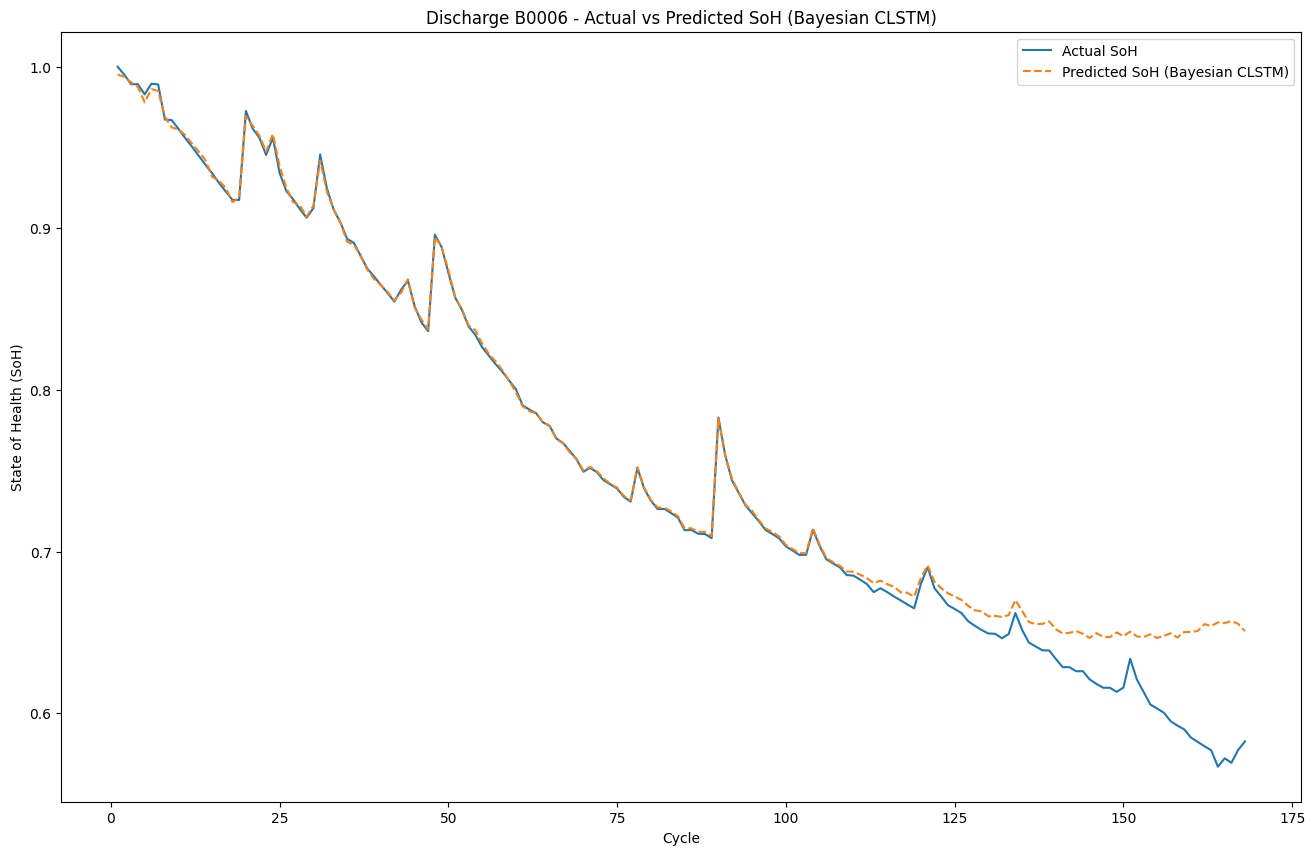

In [8]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

bayesian_clstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=False),
    MCDropout(0.25),
    tf.keras.layers.Dense(1)
])

bayesian_clstm_model.compile(optimizer='adam', loss='mean_absolute_error')
bayesian_clstm_model.summary()

history_bayesian_clstm = bayesian_clstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

bayesian_clstm_model.save('bayesian_clstm_model.h5')
bayesian_clstm_pred = bayesian_clstm_model.predict(X_train)
np.save('bayesian_clstm_predictions.npy', bayesian_clstm_pred)

bayesian_clstm_soh = prepare_soh(dataset_val, bayesian_clstm_pred, C)
plot_soh(bayesian_clstm_soh, 'Bayesian CLSTM')

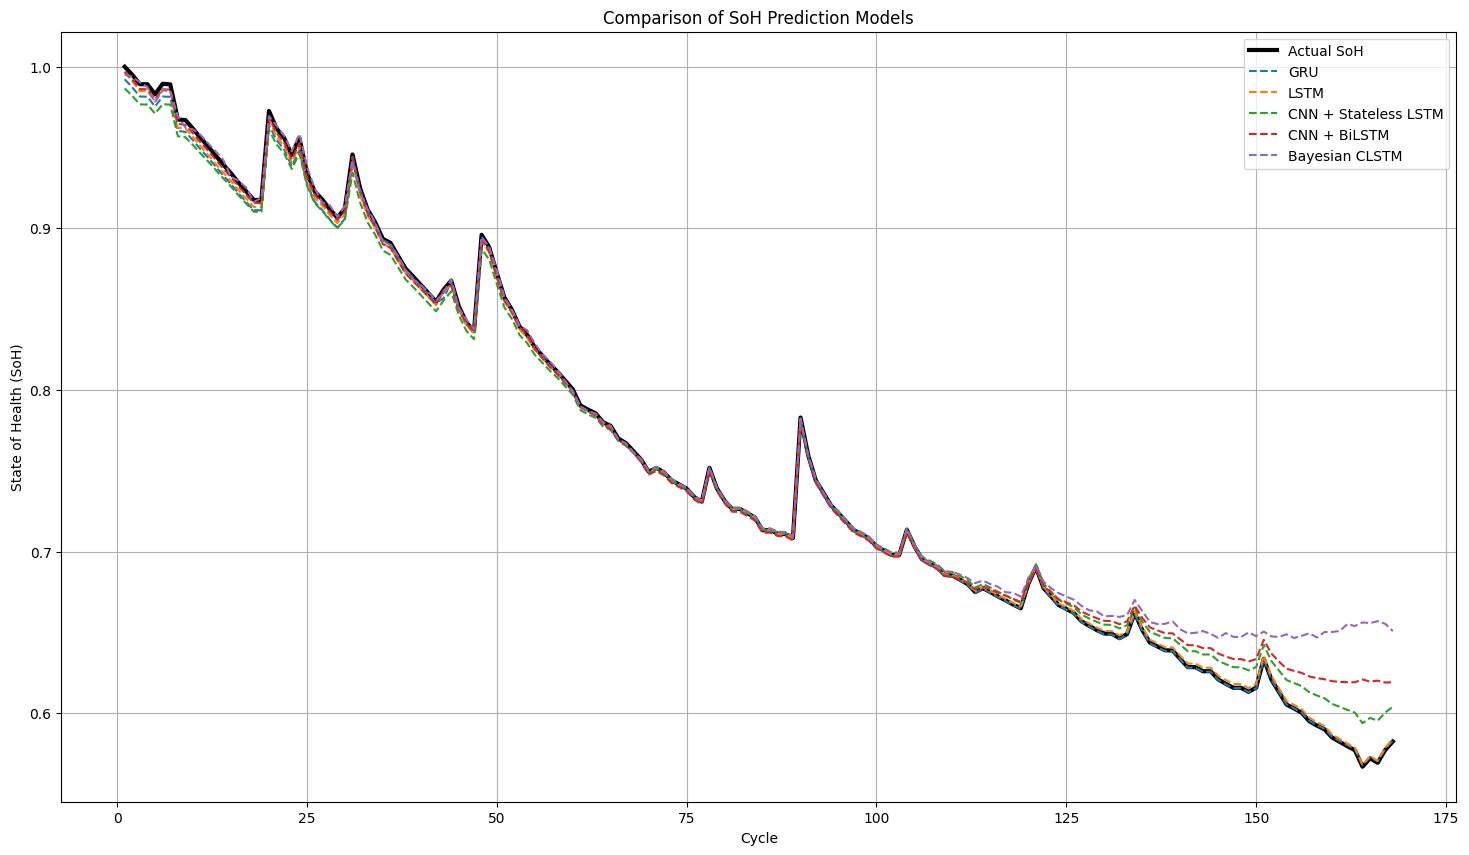

In [9]:
plt.figure(figsize=(18, 10))
plt.plot(gru_soh['cycle'], gru_soh['SoH'], label='Actual SoH', color='black', linewidth=3)

# Plot each model prediction
plt.plot(gru_soh['cycle'], gru_soh['NewSoH'], label='GRU', linestyle='--')
plt.plot(lstm_soh['cycle'], lstm_soh['NewSoH'], label='LSTM', linestyle='--')
plt.plot(cnn_lstm_soh['cycle'], cnn_lstm_soh['NewSoH'], label='CNN + Stateless LSTM', linestyle='--')
plt.plot(cnn_bilstm_soh['cycle'], cnn_bilstm_soh['NewSoH'], label='CNN + BiLSTM', linestyle='--')
plt.plot(bayesian_clstm_soh['cycle'], bayesian_clstm_soh['NewSoH'], label='Bayesian CLSTM', linestyle='--')

plt.xlabel('Cycle')
plt.ylabel('State of Health (SoH)')
plt.title('Comparison of SoH Prediction Models')
plt.legend()
plt.grid(True)
plt.show()

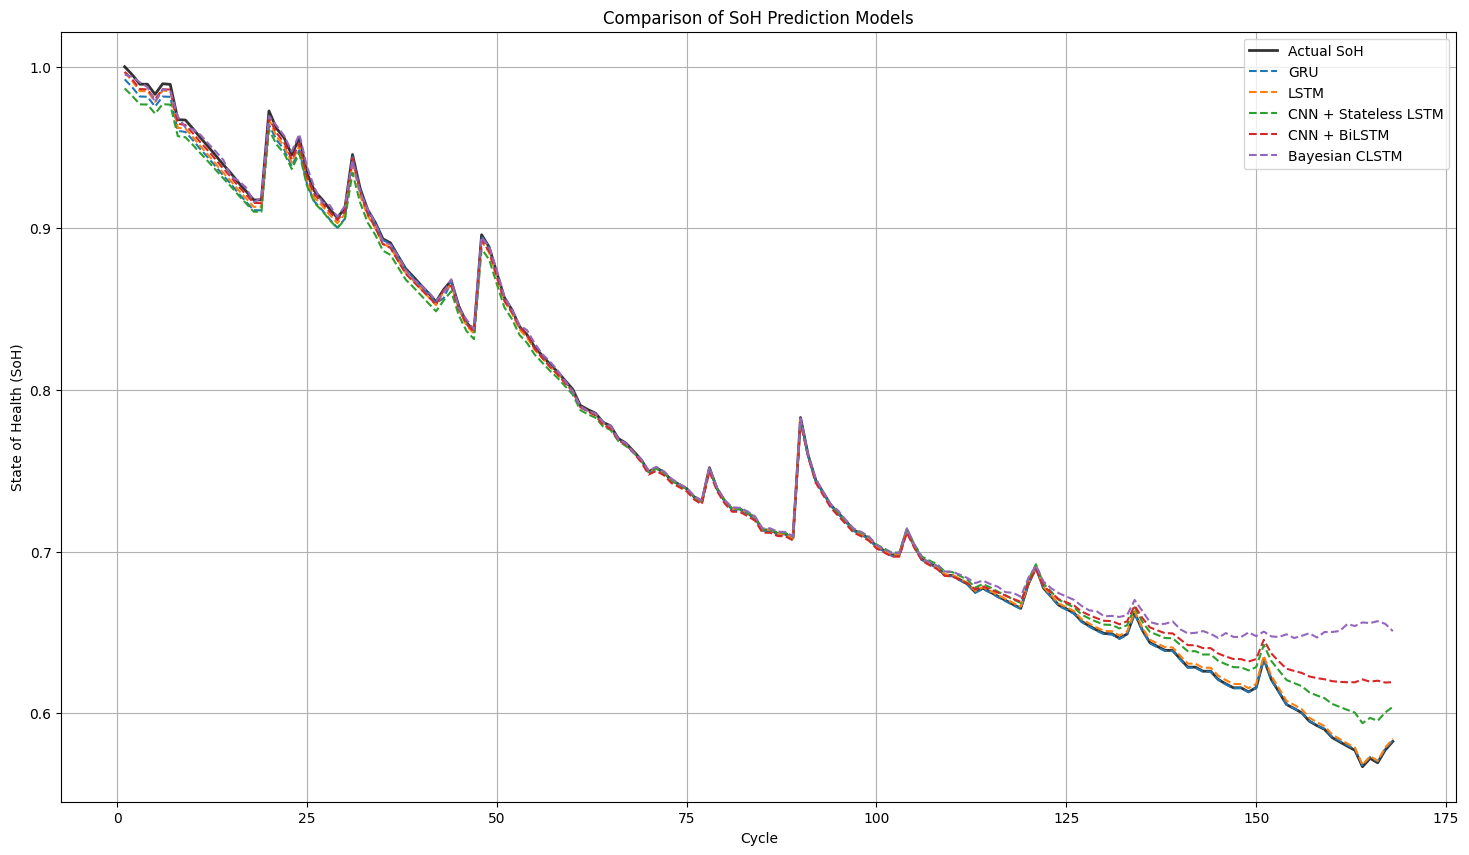

In [10]:
plt.figure(figsize=(18, 10))

# Plot Actual SoH (thinner but visible)
plt.plot(gru_soh['cycle'], gru_soh['SoH'], label='Actual SoH', color='black', linewidth=2, alpha=0.8)

# Plot each model prediction
plt.plot(gru_soh['cycle'], gru_soh['NewSoH'], label='GRU', linestyle='--')
plt.plot(lstm_soh['cycle'], lstm_soh['NewSoH'], label='LSTM', linestyle='--')
plt.plot(cnn_lstm_soh['cycle'], cnn_lstm_soh['NewSoH'], label='CNN + Stateless LSTM', linestyle='--')
plt.plot(cnn_bilstm_soh['cycle'], cnn_bilstm_soh['NewSoH'], label='CNN + BiLSTM', linestyle='--')
plt.plot(bayesian_clstm_soh['cycle'], bayesian_clstm_soh['NewSoH'], label='Bayesian CLSTM', linestyle='--')

plt.xlabel('Cycle')
plt.ylabel('State of Health (SoH)')
plt.title('Comparison of SoH Prediction Models')
plt.legend()
plt.grid(True)
plt.show()
